# Mini test matrices to judge ranking methods
Isabelle Guyon, May 14, 2020

In [1]:
# Load general libraries
import os, re
from glob import glob as ls
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns; sns.set()
from PIL import Image
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
from sys import path
eps =  np.finfo(np.float).eps

# Case 1: Consensus
All judges j provide identical ranking scores, no ties. The scores discrete and between 0 and (n-1). The winner has rank 0.

Let R[:, j] be the participant ranks given by judge j.
We consider 2 cases:
* **Larger score is better (s = -1)**: M[:, j] == R[:, j]
* **Smaller score is better (s = 1)**: M[:, j] == (n-1-R[:, j]).

We consider basic judges (based on averaging) and pariwise judges. Basic judges retain the polarity (larger score is better or lower score is better), while pairwise judges are always larger is better. For the basic judges, onne must multiply by the polarity s before sorting, and for the pariwise judges always by -1.

In [2]:
n = 6 # Number of candidates
m = 4  # Number of judges
s = -1  # Score polarity
judge0 = np.random.permutation(n)
M = np.repeat(judge0.T, m, axis=0)
M = M.reshape(n,m)
print("Score matrix")
if s==1:
    print("Smaller is better")
else:
    print("Larger is better")
M

Score matrix
Larger is better


array([[2, 2, 2, 2],
       [5, 5, 5, 5],
       [3, 3, 3, 3],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [4, 4, 4, 4]])

We call rank matrix R the matrix, which replaces the scores by ranks. A smaller rank is better. The winner is ranked 0.

In [3]:
R = np.zeros(M.shape)
for j in range(m):
    sorted_candidates = np.argsort(s*M[:,j])
    R[sorted_candidates,j] = np.arange(n)
print("Rank matrix")
print("Smaller is better")
R

Rank matrix
Smaller is better


array([[3., 3., 3., 3.],
       [0., 0., 0., 0.],
       [2., 2., 2., 2.],
       [5., 5., 5., 5.],
       [4., 4., 4., 4.],
       [1., 1., 1., 1.]])

In [4]:
if s>0:
    assert((R == M).all())
else:
    assert((n-1-R == M).all())

A judge provides a list of sorted candidates. The first one has rank 0 and corresponds to the best score.

In [5]:
sorted_candidates_0 = np.argsort(s*judge0)
print("Candidates sorted by the reference judge:")
print(sorted_candidates_0)

Candidates sorted by the reference judge:
[1 5 2 0 4 3]


## Basic judges:

Mean, median, average rank all provide the same ranking as judge0.

In [6]:
judge_dict       = { 'judge_mean': np.mean(M, axis=1),
                     'judge_median': np.median(M, axis=1),
                     'judge_ave_rank': np.mean(s*R, axis=1) } # We need to multiply rank by polarity s
print("Scores:")
for judge in judge_dict:
    print(judge, judge_dict[judge])

Scores:
judge_mean [2. 5. 3. 0. 1. 4.]
judge_median [2. 5. 3. 0. 1. 4.]
judge_ave_rank [-3.  0. -2. -5. -4. -1.]


In [7]:
print("Sorted candidates:")
for judge in judge_dict:
    sorted_candidates = np.argsort(s*judge_dict[judge]) # We need to take polarity into account
    print(judge, sorted_candidates)
    assert((sorted_candidates == sorted_candidates_0).all())

Sorted candidates:
judge_mean [1 5 2 0 4 3]
judge_median [1 5 2 0 4 3]
judge_ave_rank [1 5 2 0 4 3]


## Pairwise judges:

For the pairwise judges, LARGER is always better (those are success rates).
We compute, the relative differences, and derive from them success_rate and copeland variants. 

In [8]:
def get_relative(M, larger_is_better = True, success_rate=False, copeland=False):
    if larger_is_better:
        L = 1
    else:
        L = -1
    # Paired comparisons in performance between candidates
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # Compute performance differences, multiply by polarity to get a score larger is better
            rel_diff = 2* L * (M[i,:] - M[j,:]) / (M[i,:] + M[j,:] + eps) # Makes best sense for scores "lower is better"
            if success_rate or copeland:
                 rel_diff = rel_diff>0 
            # Compute mean
            C[i, j] = np.mean(rel_diff, axis=0)
            if copeland:
                C[i, j] = C[i, j] > 0.5
    return L*C # Restore the same polarity as M

### Relative difference:

Relative difference scores:
[ 0.12380952  0.81878307  0.43571429 -1.66666667 -0.36666667  0.65502646]


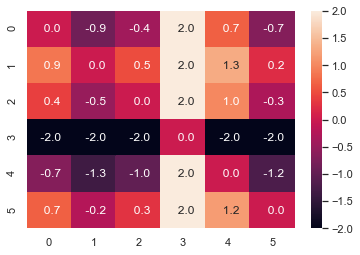

In [9]:
C = get_relative(M, larger_is_better = (s<0))
sns.heatmap(C, annot=True, fmt='5.1f')
judge_rel_diff = np.mean(C, axis=1)
print("Relative difference scores:")
print(judge_rel_diff)

The candidates are still in line. The judges are performances against other candidates, larger is better, found in column. 
We verify that the relative difference judge gives the same ranking:

### Success rate:
Success rate uses as a ranking criterion the number of wins in pair matches, accross all candidate pariwise comparisons and all judges. One can use the relative difference matrix and threshold it. A positive number means a win.

Success rate scores:
[0.33333333 0.83333333 0.5        0.         0.16666667 0.66666667]


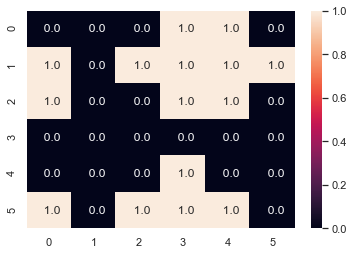

In [10]:
C = get_relative(M, larger_is_better = (s<0), success_rate=True)
sns.heatmap(C, annot=True, fmt='5.1f')
judge_success_rate = np.mean(C, axis=1)
print("Success rate scores:")
print(judge_success_rate)

### Copeland:
[Copeland](https://en.wikipedia.org/wiki/Copeland%27s_method#:~:text=Copeland's%20method%20is%20a%20ranked,referred%20to%20as%20%22Llull's%20method%22) is simular as success rate, but, in a match between a pair of candidates, one considers that there is a win of the majority of judges prefers a candidate. 

Copeland scores:
[0.33333333 0.83333333 0.5        0.         0.16666667 0.66666667]


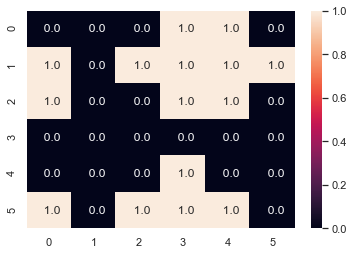

In [11]:
C = get_relative(M, larger_is_better = (s<0), copeland=True)
sns.heatmap(C, annot=True, fmt='5.1f')
judge_copeland = np.mean(C, axis=1)
print("Copeland scores:")
print(judge_copeland)

### Verify all pairwise judges give the same result as judge0:

In [12]:
judge_dict       = { 'judge_rel_diff': judge_rel_diff,
                     'judge_success_rate': judge_success_rate,
                     'judge_copeland': judge_copeland }
print("Sorted candidates:")
for judge in judge_dict:
    print(judge, np.argsort(s*judge_dict[judge]))  # Pairwise scores are all success rates
    assert((sorted_candidates == sorted_candidates_0).all())

Sorted candidates:
judge_rel_diff [1 5 2 0 4 3]
judge_success_rate [1 5 2 0 4 3]
judge_copeland [1 5 2 0 4 3]


### Summarize results:

In [13]:
def show_judgements(M):
    judge_dict   = { 'judge_mean': np.mean(M, axis=1),
                     'judge_median': np.median(M, axis=1),
                     'judge_ave_rank': np.mean(s*R, axis=1), # We need to multiply rank by polarity s
                     'judge_rel_diff': np.mean(get_relative(M, larger_is_better = (s<0)), axis=1),
                     'judge_success_rate': np.mean(get_relative(M, larger_is_better = (s<0), success_rate=True), axis=1),
                     'judge_copeland': np.mean(get_relative(M, larger_is_better = (s<0), copeland=True), axis=1) } 

    judgement = judge_dict.copy()
    print("Scores:")
    for judge in judge_dict:
        print(judge, judge_dict[judge])

    print("\nSorted candidates:")
    for judge in judge_dict:
        judgement[judge] = np.argsort(s*judge_dict[judge])
        print(judge, judgement[judge]) 
    return judge_dict, judgement

judge_consensus, judgement_consensus = show_judgements(M)

Scores:
judge_mean [2. 5. 3. 0. 1. 4.]
judge_median [2. 5. 3. 0. 1. 4.]
judge_ave_rank [-3.  0. -2. -5. -4. -1.]
judge_rel_diff [ 0.12380952  0.81878307  0.43571429 -1.66666667 -0.36666667  0.65502646]
judge_success_rate [0.33333333 0.83333333 0.5        0.         0.16666667 0.66666667]
judge_copeland [0.33333333 0.83333333 0.5        0.         0.16666667 0.66666667]

Sorted candidates:
judge_mean [1 5 2 0 4 3]
judge_median [1 5 2 0 4 3]
judge_ave_rank [1 5 2 0 4 3]
judge_rel_diff [1 5 2 0 4 3]
judge_success_rate [1 5 2 0 4 3]
judge_copeland [1 5 2 0 4 3]


# Case 2: Antagonist judges
Half of the judges have the opposite opinion of the other half.

In [14]:
M = np.concatenate((judge0, judge0, n-1-judge0, n-1-judge0))
M = M.reshape(m,n).T
M

array([[2, 2, 3, 3],
       [5, 5, 0, 0],
       [3, 3, 2, 2],
       [0, 0, 5, 5],
       [1, 1, 4, 4],
       [4, 4, 1, 1]])

Get the rank matrix:

In [15]:
R = np.zeros(M.shape)
for j in range(m):
    sorted_candidates = np.argsort(s*M[:,j])
    R[sorted_candidates,j] = np.arange(n)
R

array([[3., 3., 2., 2.],
       [0., 0., 5., 5.],
       [2., 2., 3., 3.],
       [5., 5., 0., 0.],
       [4., 4., 1., 1.],
       [1., 1., 4., 4.]])

In [16]:
judge_antagonist, judgement_antagonist = show_judgements(M)

Scores:
judge_mean [2.5 2.5 2.5 2.5 2.5 2.5]
judge_median [2.5 2.5 2.5 2.5 2.5 2.5]
judge_ave_rank [-2.5 -2.5 -2.5 -2.5 -2.5 -2.5]
judge_rel_diff [ 0.2797619  -0.4239418   0.2797619  -0.4239418   0.14417989  0.14417989]
judge_success_rate [0.41666667 0.41666667 0.41666667 0.41666667 0.41666667 0.41666667]
judge_copeland [0. 0. 0. 0. 0. 0.]

Sorted candidates:
judge_mean [0 1 2 3 4 5]
judge_median [0 1 2 3 4 5]
judge_ave_rank [0 1 2 3 4 5]
judge_rel_diff [0 2 4 5 1 3]
judge_success_rate [0 1 2 3 4 5]
judge_copeland [0 1 2 3 4 5]


Argsort does not handle ties, they are arbitrarily broken.

Relative difference is the only method not having a n-way tie. There are tie pairs only. If s=-1 (largest scores are best), the candidates on which the judges least disagree win! This is a good thing if what we want is to find a generalist method that never does horribly bad on any task. However, if s=1 (smallest scores are best) it is the opposite; then candidates which do well on at least a subset of tasks win. Thus "relative difference" either correlate or anti-correlate with judge variance.

In [17]:
judge_variance = np.var(M, axis=1)
judge_variance

array([0.25, 6.25, 0.25, 6.25, 2.25, 2.25])

In [18]:
judgement_variance = np.argsort(-s*judge_variance)
judgement_variance

array([0, 2, 4, 5, 1, 3])

### Stability is case of antagonist judges
One can see that for all methods but "relative difference", removing one judge with change eveything COMPLETELY.

In [19]:
M = M[:,1:]
M

array([[2, 3, 3],
       [5, 0, 0],
       [3, 2, 2],
       [0, 5, 5],
       [1, 4, 4],
       [4, 1, 1]])

In [20]:
R = R[:,1:]
R

array([[3., 2., 2.],
       [0., 5., 5.],
       [2., 3., 3.],
       [5., 0., 0.],
       [4., 1., 1.],
       [1., 4., 4.]])

In [21]:
judge_perturbated, judgement_perturbated = show_judgements(M)

Scores:
judge_mean [2.66666667 1.66666667 2.33333333 3.33333333 3.         2.        ]
judge_median [3. 0. 2. 5. 4. 1.]
judge_ave_rank [-2.33333333 -3.33333333 -2.66666667 -1.66666667 -2.         -3.        ]
judge_rel_diff [ 0.33174603 -0.83818342  0.22777778 -0.00970018  0.31446208 -0.02610229]
judge_success_rate [0.44444444 0.27777778 0.38888889 0.55555556 0.5        0.33333333]
judge_copeland [0.5        0.         0.33333333 0.83333333 0.66666667 0.16666667]

Sorted candidates:
judge_mean [3 4 0 2 5 1]
judge_median [3 4 0 2 5 1]
judge_ave_rank [3 4 0 2 5 1]
judge_rel_diff [0 4 2 3 5 1]
judge_success_rate [3 4 0 2 5 1]
judge_copeland [3 4 0 2 5 1]


They all agree, except "relative difference", which has a verdict which could on average be more similar to its previous opinion, since the other methods had a tie. **This explains why relative difference is more stable in the case of the artificial data, which is similar to the case of antagonist judges**.

In [22]:
for judge in judge_perturbated:
    c = np.corrcoef(judge_antagonist[judge], judge_perturbated[judge])[0,1]
    print(judge, c)

judge_mean nan
judge_median nan
judge_ave_rank nan
judge_rel_diff 0.7604560658162847
judge_success_rate nan
judge_copeland nan


**Warning** for relative difference: The effect is difference if scores are the LARGER the better or the SMALLER the better. For Dassault we had MAE => the smaller the better. Thus the difference is blown up for "good" performance (small MAE), and we do not penalize as much in regions where both methods do poorly. Does it make sense?

If scores can take negative values, we could change the sign of the difference when we divide by a negative mean value. Here we do not have this problem (neither for MAE). But if we use a relative difference score, **we must impose that the scores are positive**.

When we use a score the larger the better, it is the opposite: differences are attenuated when the scores are high (good). This seems to be the case when the results of "relative difference" make best sense in the case of antagonist judges.

In the future, we might want to adopt a **uniform convention**. Perhaps we should always assume that scores are positive or zero and the larger the better. Perhaps even all normalized between 0 and 1 like probabilities. If scores are the smaller the better and between 0 and +inf (like an energy, a MAE, a MSE, or a negative log likelyhood) they can be converted to a score between 0 and 1, the larger the better, with exp(- beta x), where beta is a positive number. But of course, if the scores are normalized, then the methods perform more similarly (particularly, mean/median/average rank).